In [1]:
import os
import fsspec
import tqdm

import datamol as dm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu, ranksums
from collections import defaultdict

from mood.visualize import plot_distance_distributions
from mood.dataset import MOOD_DATASETS
from mood.utils import get_outlier_bounds
from mood.representations import MOOD_REPRESENTATIONS

/Users/cas.wognum/micromamba/envs/mood/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GLOB_PATTERN = "gs://experiments-output/mood-v2/results/numpy/compare_spaces/20221216/*.npy"

In [3]:
paths = dm.fs.glob(GLOB_PATTERN)
paths[:3]

['gcs://experiments-output/mood-v2/results/numpy/compare_spaces/20221216/BBB_ChemBERTa_Optimization_GP_space.npy',
 'gcs://experiments-output/mood-v2/results/numpy/compare_spaces/20221216/BBB_ChemBERTa_Optimization_MLP_space.npy',
 'gcs://experiments-output/mood-v2/results/numpy/compare_spaces/20221216/BBB_ChemBERTa_Optimization_RF_space.npy']

In [4]:
def load_as_dataframe(path):
    
    basename = dm.fs.get_basename(path)
    basename = os.path.splitext(basename)[0]
    dataset, representation, subset, space, _ = basename.split("_")
    
    with fsspec.open(path, "rb") as fd:
        distances = np.load(fd)
        
    df_ = pd.DataFrame({
        "Dataset": dataset,
        "Representation": representation,
        "Subset": subset.capitalize(),
        "Space": space,
        "Distances": [distances],
    }, index=[0])
    return df_


dfs = dm.utils.parallelized(load_as_dataframe, paths, progress=True, n_jobs=-1)

  0%|                                                   | 0/768 [00:00<?, ?it/s]/Users/cas.wognum/micromamba/envs/mood/lib/python3.10/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/cas.wognum/micromamba/envs/mood/lib/python3.10/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/cas.wog

In [5]:
df = pd.concat(dfs, ignore_index=True)
df.head()

Dataset Representation        Subset  Space  \
0     BBB      ChemBERTa  Optimization     GP   
1     BBB      ChemBERTa  Optimization    MLP   
2     BBB      ChemBERTa  Optimization     RF   
3     BBB      ChemBERTa  Optimization  input   
4     BBB      ChemBERTa         Train     GP   

                                           Distances  
0  [10.78544867493246, 9.438141990033781, 10.0813...  
1  [12.120924144054124, 9.341725834494317, 12.101...  
2  [10.80584763811565, 9.086419549758512, 10.6616...  
3  [21.47773003753199, 19.018381322352234, 21.218...  
4  [6.77729720924593, 7.025933365583461, 6.863862...

In [6]:
def plot(df, dataset, spaces, cols=None, rows=None):
    df = df[df["Dataset"] == dataset]
    df = df[df["Space"].isin(spaces)]
    
    if cols is None:
        cols = df["Space"].unique()
    if rows is None:
        rows = df["Representation"].unique()
    
    fig, axs = plt.subplots(ncols=len(cols), nrows=len(rows), figsize=(6 * len(cols), 3 * len(rows)))
    if axs.ndim < 2:
        axs = axs[:, np.newaxis]
    
    for ri, representation in enumerate(rows):
        for ci, space in enumerate(cols):
            
            group = df[df["Representation"] == representation]
            group = group[group["Space"] == space]
            
            if group.empty:
                axs[ri][ci].axis("off")
                continue
            
            group["Subset"] = pd.Categorical(group["Subset"], ["Train", "Virtual screening", "Optimization"])
            group = group.sort_values("Subset")
            
            distances = group["Distances"].tolist()
            labels = group["Subset"].tolist()
            
            ax = plot_distance_distributions(distances, labels=labels, ax=axs[ri][ci])
            
            if ci == 0: 
                x_min, x_max = ax.get_xlim()
                x = x_min - (x_max - x_min) / 10
                y_min, y_max = ax.get_ylim() 
                y = y_min + (y_max - y_min) / 2
                ax.text(x, y, representation, rotation="vertical", va="center")
            if ri == 0: 
                ax.set_title(f"{space} space")
            if ri == len(rows) - 1: 
                ax.set_xlabel("Distance")
            else: 
                ax.set_xlabel("")
    
    fig.suptitle(dataset, fontsize=18, y=1)
    plt.tight_layout()


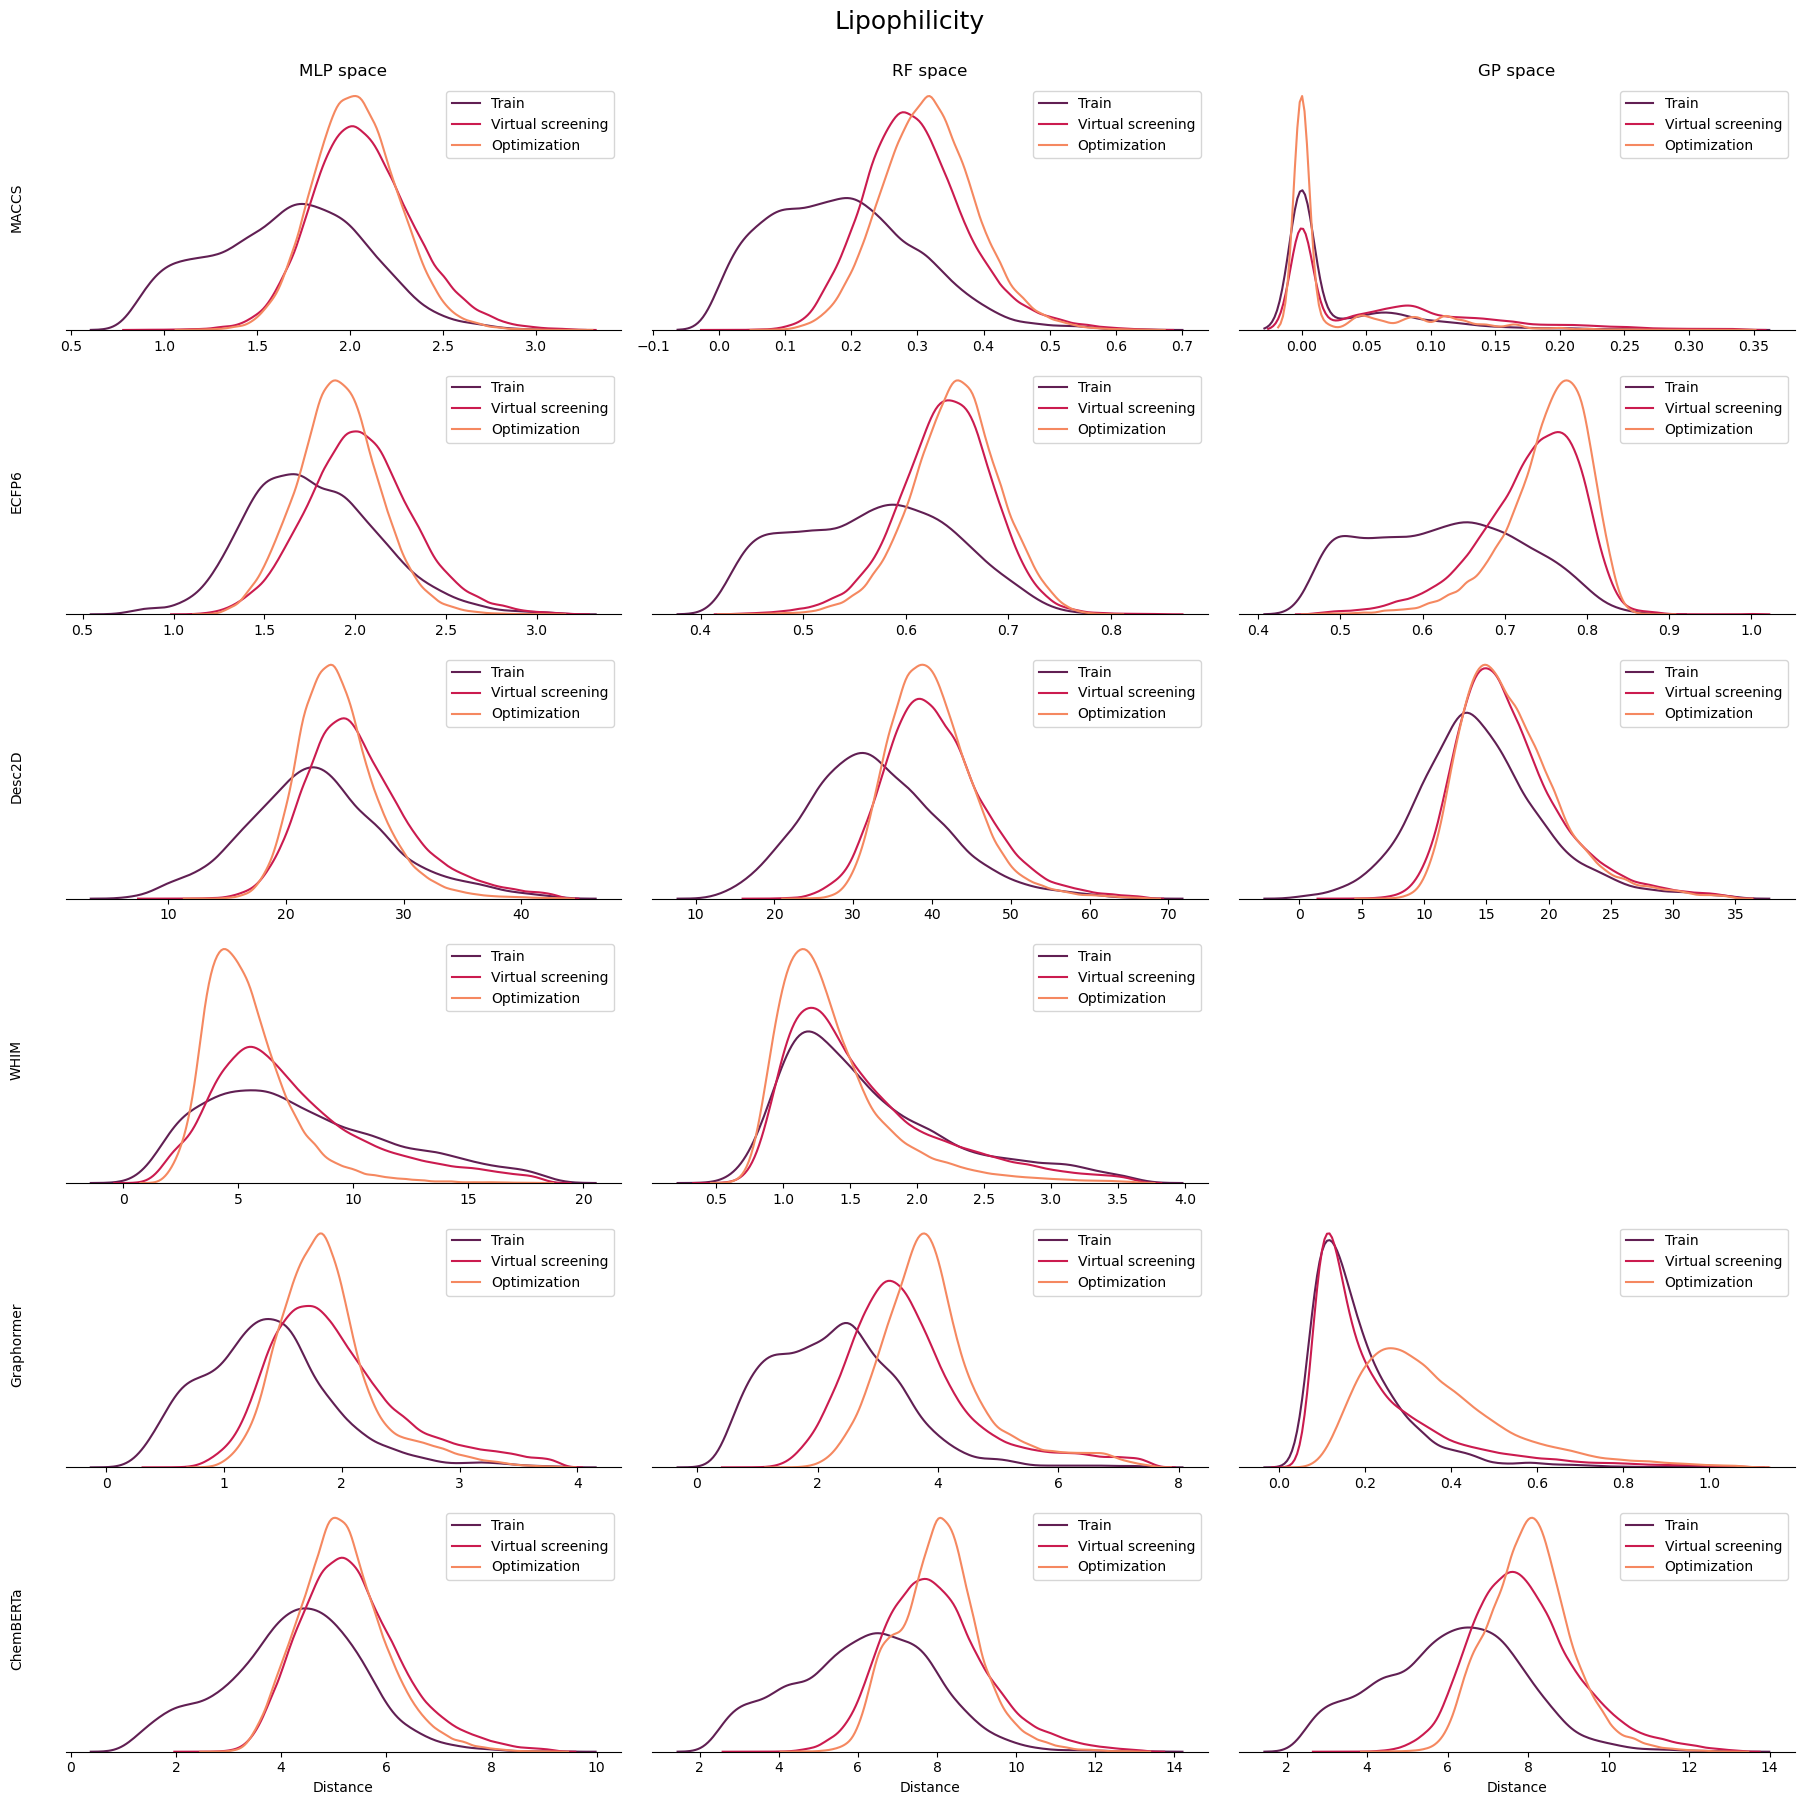

In [7]:
plot(df, "Lipophilicity", ["GP", "MLP", "RF"], cols=["MLP", "RF", "GP"], rows=["MACCS", "ECFP6", "Desc2D", "WHIM", "Graphormer", "ChemBERTa"])

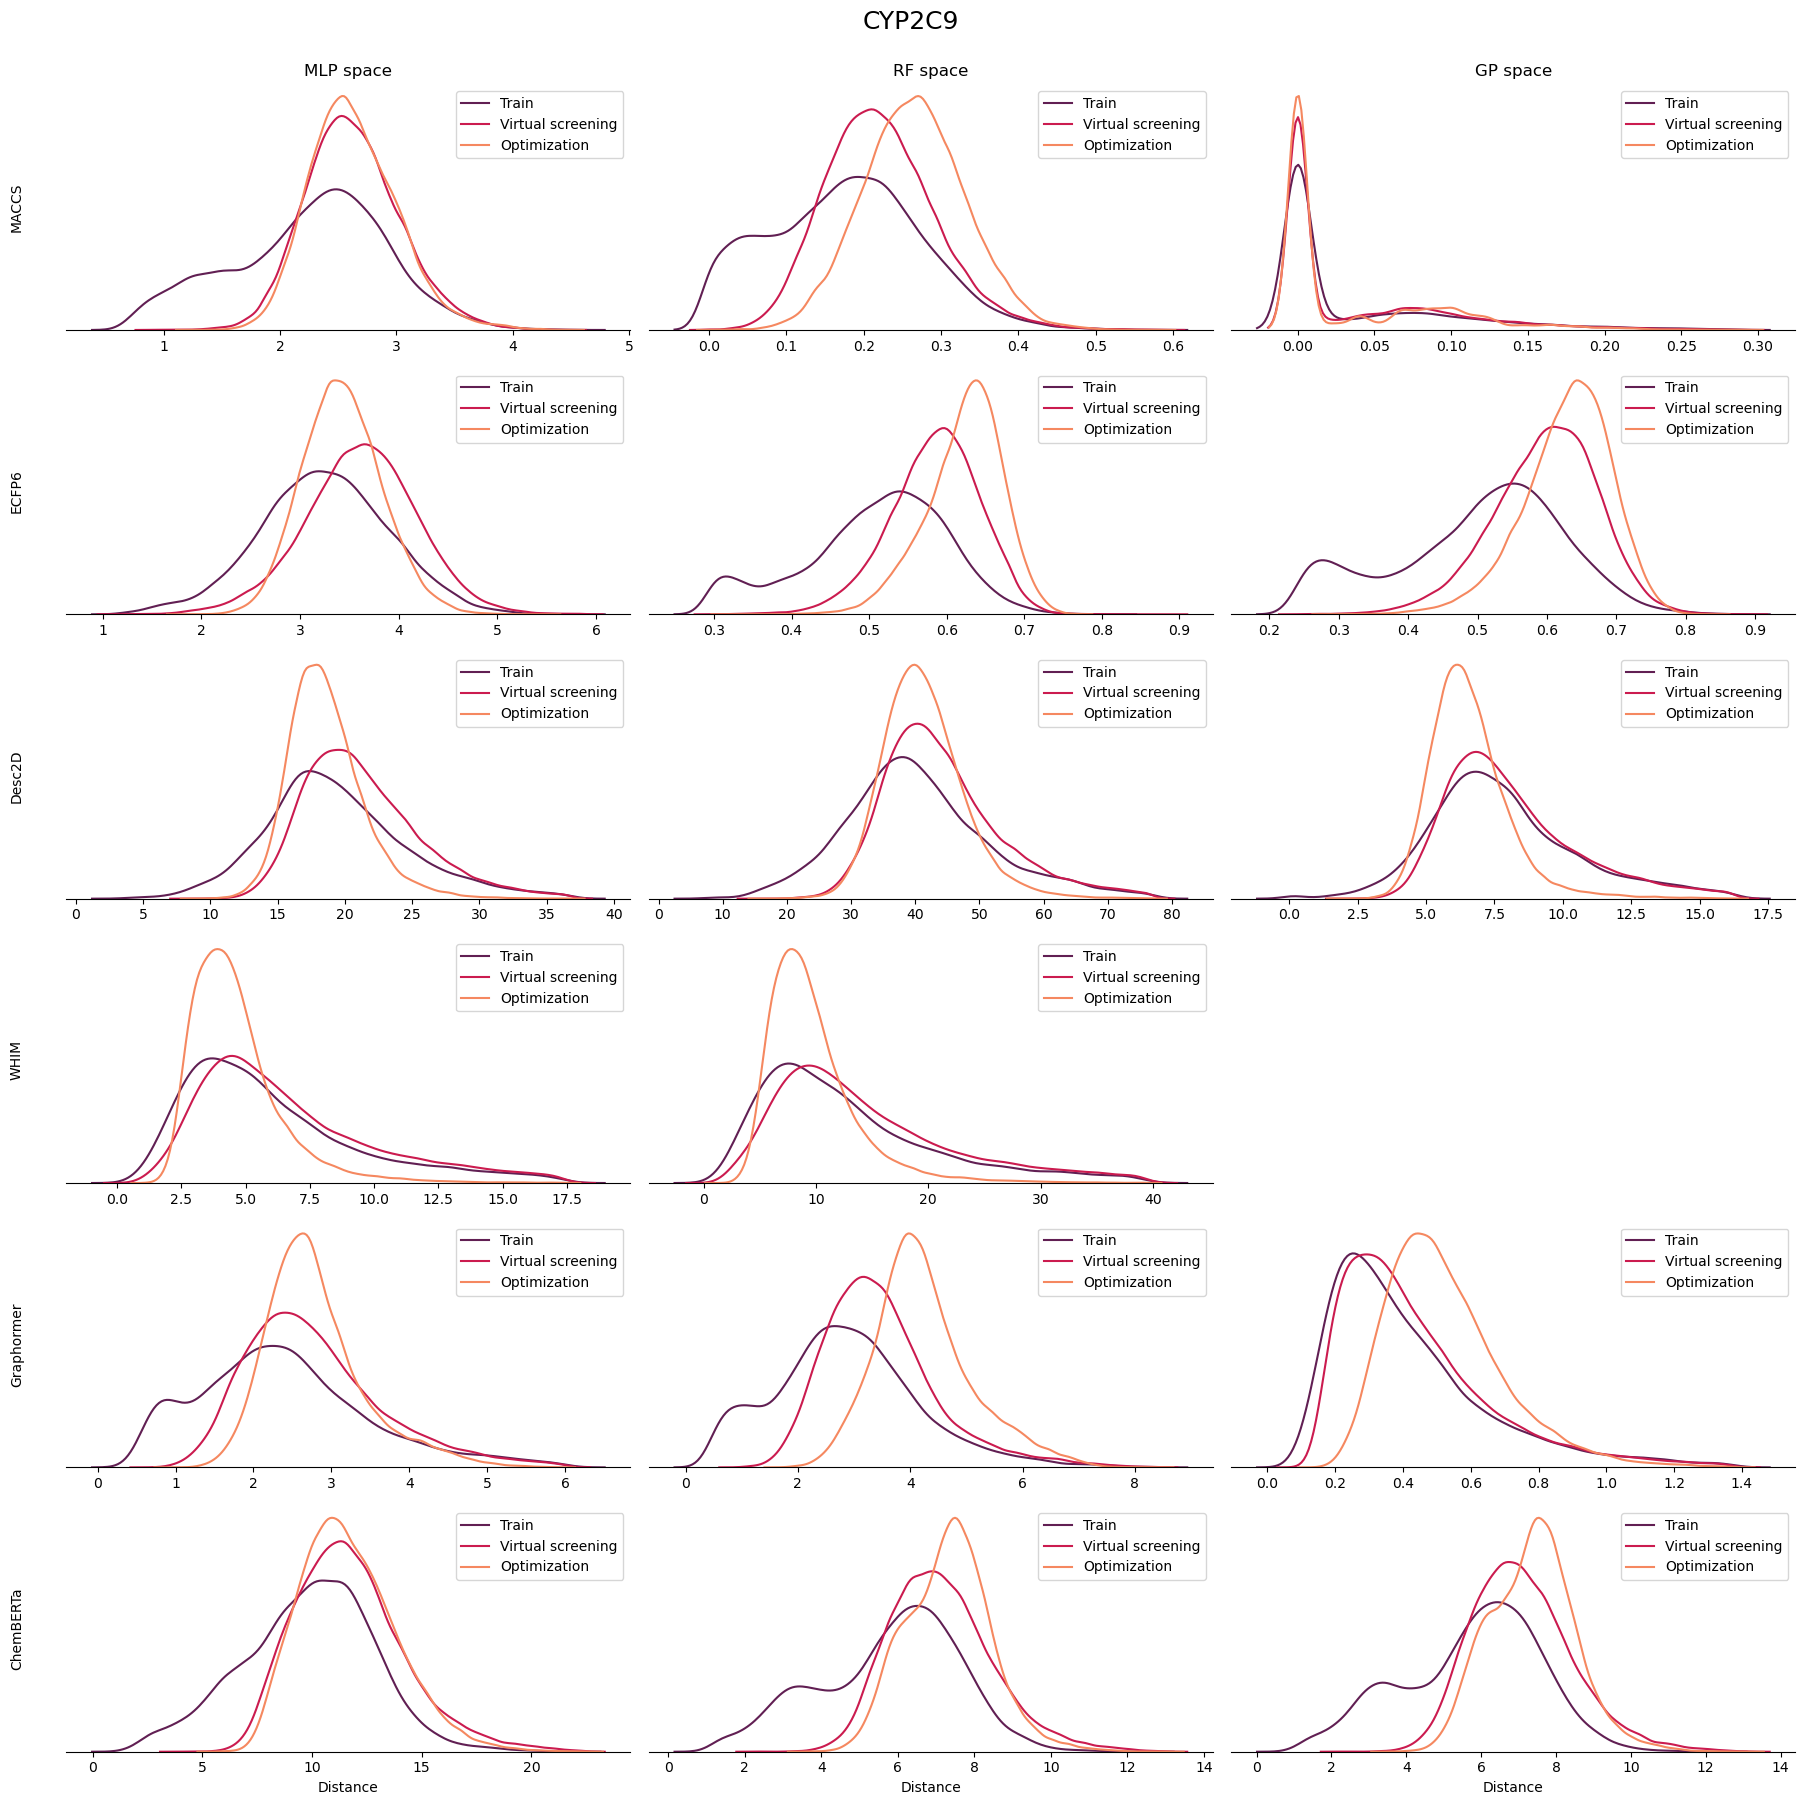

In [8]:
plot(df, "CYP2C9", ["GP", "MLP", "RF"], cols=["MLP", "RF", "GP"], rows=["MACCS", "ECFP6", "Desc2D", "WHIM", "Graphormer", "ChemBERTa"])

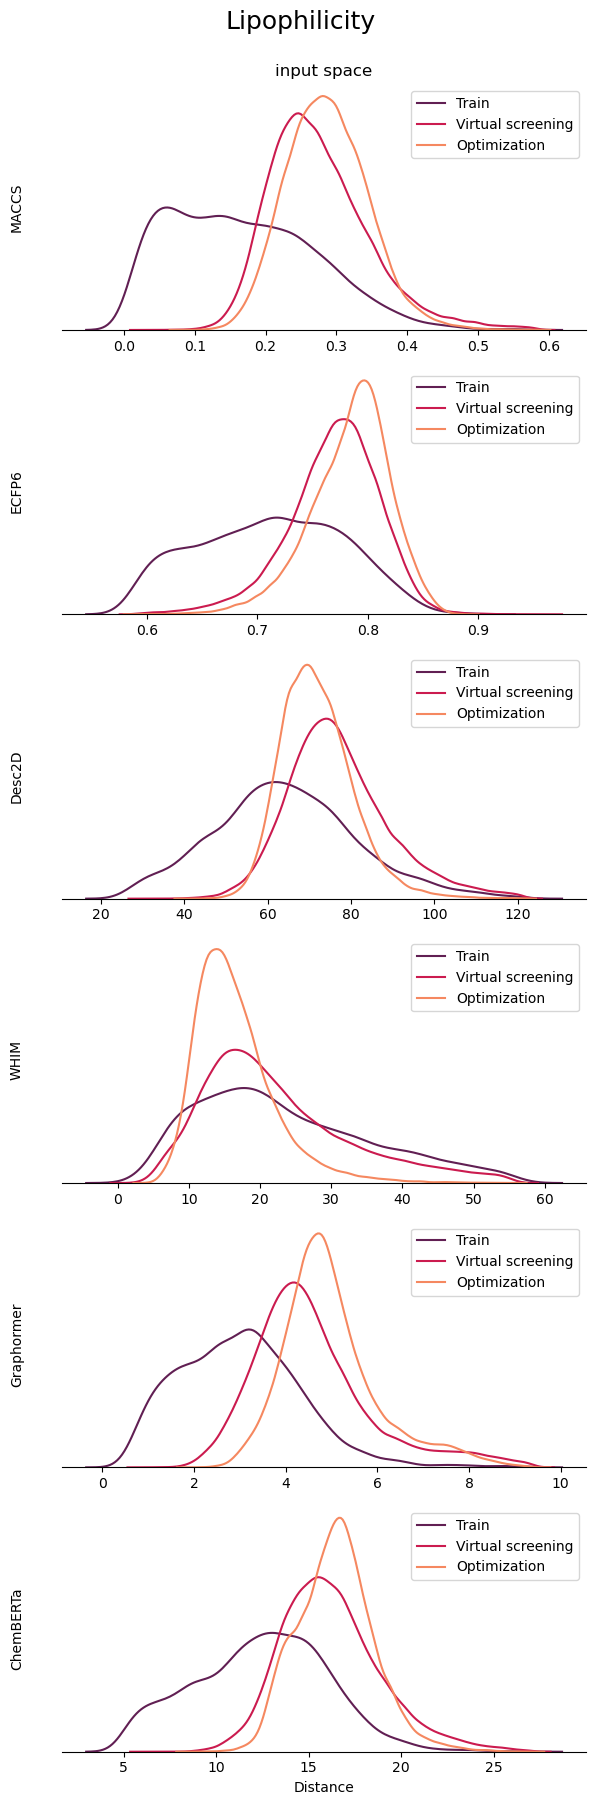

In [9]:
plot(df, "Lipophilicity", ["input"], cols=["input"], rows=["MACCS", "ECFP6", "Desc2D", "WHIM", "Graphormer", "ChemBERTa"])

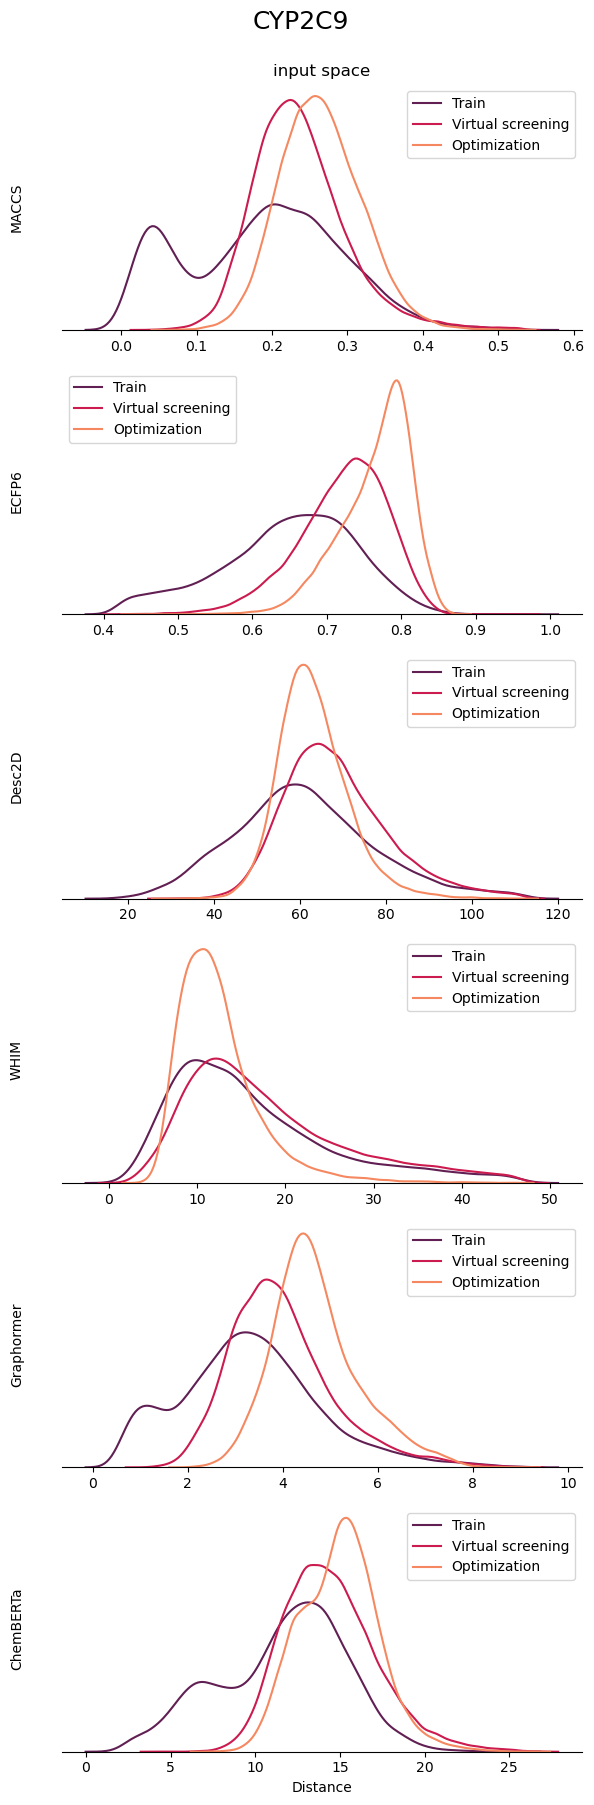

In [10]:
plot(df, "CYP2C9", ["input"], cols=["input"], rows=["MACCS", "ECFP6", "Desc2D", "WHIM", "Graphormer", "ChemBERTa"])

# Boxenplot
This is meant to condense the information in a smaller, easier to read plot suited for publications

In [11]:
def plot_distances_as_boxen(df, ax, title, palette):
    
    ax = sns.boxenplot(
        data=df, 
        y="Distances", 
        x="Representation", 
        hue="Subset", 
        hue_order=["Train", "Virtual screening", "Optimization"],
        ax=ax,
        palette=palette
    )
        
    # Simplify the plot
    ax.get_legend().remove()
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.xaxis.set_ticks([])
    
    ax.set_ylabel("")
    ax.set_xlabel(title)
    return ax

    
def plot_condensed(df, space, dataset, palette, legend: bool = False):
    
    df = df[df["Space"] == space]
    df = df[df["Dataset"] == dataset]
    df = df.explode("Distances")
    
    fig, axs = plt.subplots(ncols=len(MOOD_REPRESENTATIONS), figsize=(12, 4))
    for idx, representation in enumerate(MOOD_REPRESENTATIONS):
        
        group = df[df["Representation"] == representation]
        
        if group.empty:
            axs[idx].axis("off")
            axs[idx].set_xlabel(representation)
            continue
        
        lower, upper = get_outlier_bounds(group["Distances"].to_numpy(), factor=3)
        group = group[(group["Distances"] >= lower) & (group["Distances"] <= upper)]
        
        ax = plot_distances_as_boxen(group, axs[idx], representation, palette)
            
        if idx == 0: 
            ax.set_ylabel("Distance")
            
    plt.tight_layout()
    if legend: 
        
        legend_lines = [
            plt.Line2D([0], [0], color=palette[0], lw=4),
            plt.Line2D([0], [0], color=palette[1], lw=4),
            plt.Line2D([0], [0], color=palette[2], lw=4),
        ]
        labels = ["Train", "Virtual screening", "Optimization"]

        fig.legend(
            legend_lines,
            labels,
            fontsize=12,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.1),
            bbox_transform=plt.gcf().transFigure, 
            ncol=3,
            fancybox=True
        )
        
        fig.suptitle(f"Distance distributions in the {space if space.isupper() else space.capitalize()} space", y=1.05)
        
    return fig


In [12]:
palette = sns.color_palette("Set2", 12)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

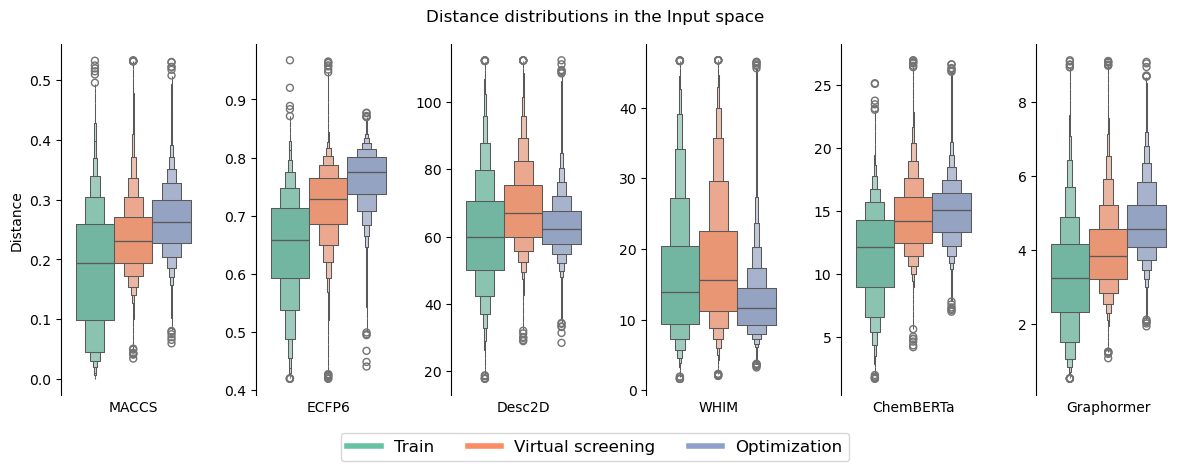

In [13]:
plot_condensed(df, "input", "CYP2C9", palette, True);

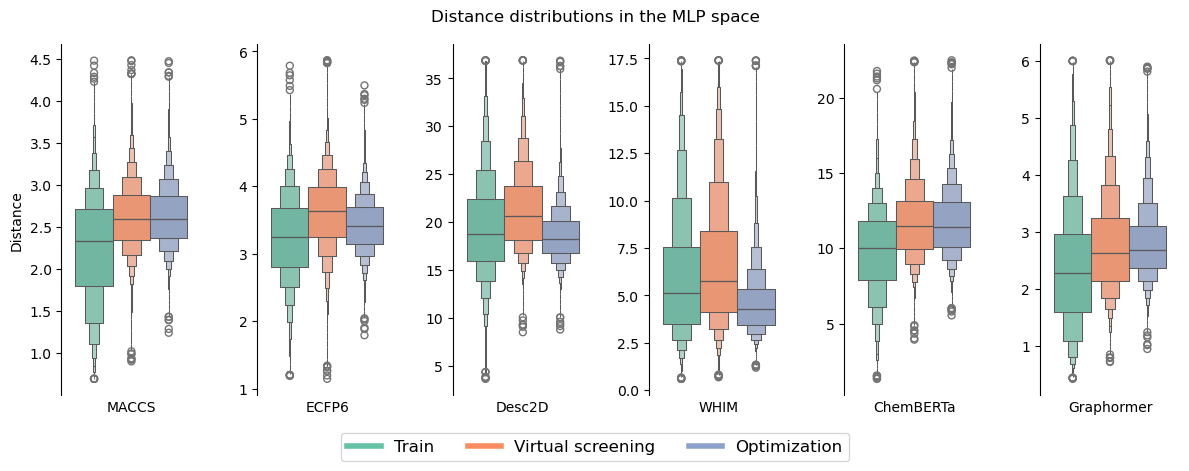

In [14]:
plot_condensed(df, "MLP", "CYP2C9", palette, True);

# Statistical testing

In [15]:
def do_statistical_test(df, space, dataset):
    
    df = df[df["Space"] == space]
    df = df[df["Dataset"] == dataset]
    df = df.explode("Distances")

    stats = pd.DataFrame(columns=["Subset", "Test", "p-value"])
    
    for idx, representation in enumerate(MOOD_REPRESENTATIONS):
        
        group = df[df["Representation"] == representation]
        
        lower, upper = get_outlier_bounds(group["Distances"].to_numpy(), factor=3)
        group = group[(group["Distances"] >= lower) & (group["Distances"] <= upper)]

        train = group[group["Subset"] == "Train"]["Distances"].to_numpy().astype(float)

        for subset in ["Virtual screening", "Optimization"]:
            subset_dist = group[group["Subset"] == subset]["Distances"].to_numpy().astype(float)
            
            stats.loc[len(stats)] = [subset, "t-test", ttest_ind(train, subset_dist)[1]]
            stats.loc[len(stats)] = [subset, "Mann-Whitney U test", mannwhitneyu(train, subset_dist).pvalue]
            stats.loc[len(stats)] = [subset, "Wilcoxon rank-sum statistic", ranksums(train, subset_dist).pvalue]
        
    return stats

In [16]:
do_statistical_test(df, "MLP", "CYP2C9")

Subset                         Test        p-value
0   Virtual screening                       t-test   0.000000e+00
1   Virtual screening          Mann-Whitney U test   0.000000e+00
2   Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
3        Optimization                       t-test   0.000000e+00
4        Optimization          Mann-Whitney U test   0.000000e+00
5        Optimization  Wilcoxon rank-sum statistic   0.000000e+00
6   Virtual screening                       t-test   0.000000e+00
7   Virtual screening          Mann-Whitney U test   0.000000e+00
8   Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
9        Optimization                       t-test   0.000000e+00
10       Optimization          Mann-Whitney U test  7.194133e-212
11       Optimization  Wilcoxon rank-sum statistic  7.194065e-212
12  Virtual screening                       t-test   0.000000e+00
13  Virtual screening          Mann-Whitney U test   0.000000e+00
14  Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
15       Optimization                       t-test   6.345947e-99
16       Optimization          Mann-Whitney U test   5.208697e-26
17       Optimization  Wilcoxon rank-sum statistic   5.208680e-26
18  Virtual screening                       t-test   2.660936e-75
19  Virtual screening          Mann-Whitney U test  1.995816e-106
20  Virtual screening  Wilcoxon rank-sum statistic  1.995802e-106
21       Optimization                       t-test   0.000000e+00
22       Optimization          Mann-Whitney U test  2.741071e-243
23       Optimization  Wilcoxon rank-sum statistic  2.741042e-243
24  Virtual screening                       t-test   0.000000e+00
25  Virtual screening          Mann-Whitney U test   0.000000e+00
26  Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
27       Optimization                       t-test   0.000000e+00
28       Optimization          Mann-Whitney U test   0.000000e+00
29       Optimization  Wilcoxon rank-sum statistic   0.000000e+00
30  Virtual screening                       t-test   0.000000e+00
31  Virtual screening          Mann-Whitney U test   0.000000e+00
32  Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
33       Optimization                       t-test   0.000000e+00
34       Optimization          Mann-Whitney U test   0.000000e+00
35       Optimization  Wilcoxon rank-sum statistic   0.000000e+00

In [17]:
do_statistical_test(df, "input", "CYP2C9")

Subset                         Test        p-value
0   Virtual screening                       t-test   0.000000e+00
1   Virtual screening          Mann-Whitney U test   0.000000e+00
2   Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
3        Optimization                       t-test   0.000000e+00
4        Optimization          Mann-Whitney U test   0.000000e+00
5        Optimization  Wilcoxon rank-sum statistic   0.000000e+00
6   Virtual screening                       t-test   0.000000e+00
7   Virtual screening          Mann-Whitney U test   0.000000e+00
8   Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
9        Optimization                       t-test   0.000000e+00
10       Optimization          Mann-Whitney U test   0.000000e+00
11       Optimization  Wilcoxon rank-sum statistic   0.000000e+00
12  Virtual screening                       t-test   0.000000e+00
13  Virtual screening          Mann-Whitney U test   0.000000e+00
14  Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
15       Optimization                       t-test   1.506393e-95
16       Optimization          Mann-Whitney U test  3.874926e-107
17       Optimization  Wilcoxon rank-sum statistic  3.874899e-107
18  Virtual screening                       t-test   7.926935e-78
19  Virtual screening          Mann-Whitney U test  1.692232e-111
20  Virtual screening  Wilcoxon rank-sum statistic  1.692220e-111
21       Optimization                       t-test   0.000000e+00
22       Optimization          Mann-Whitney U test  8.764847e-239
23       Optimization  Wilcoxon rank-sum statistic  8.764755e-239
24  Virtual screening                       t-test   0.000000e+00
25  Virtual screening          Mann-Whitney U test   0.000000e+00
26  Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
27       Optimization                       t-test   0.000000e+00
28       Optimization          Mann-Whitney U test   0.000000e+00
29       Optimization  Wilcoxon rank-sum statistic   0.000000e+00
30  Virtual screening                       t-test   0.000000e+00
31  Virtual screening          Mann-Whitney U test   0.000000e+00
32  Virtual screening  Wilcoxon rank-sum statistic   0.000000e+00
33       Optimization                       t-test   0.000000e+00
34       Optimization          Mann-Whitney U test   0.000000e+00
35       Optimization  Wilcoxon rank-sum statistic   0.000000e+00

The End.